# Forecasting Weather with LSTM Recurrent Neural Networks (12)
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)


#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


In [2]:
import numpy
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-2*look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + 2*look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

## 2. Extracting Data and Transforming Data

In [6]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

In [8]:
# Extrai dados Climáticos da Estação Selecionada
weather = list(db.meteo_data_weather_data.find({'weather_station_id': ObjectId('598f58415718dd578b4c8255')}))
weather_normalized = pd.io.json.json_normalize(weather)
df_weather = pd.DataFrame(weather_normalized[['analysis_date', 'weather_forecast.med_temp']])
df_weather = df_weather.set_index('analysis_date')
ts_weather = df_weather['2000-01-01':'2017-08-11'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_weather.head()

,weather_forecast.med_temp
analysis_date,
2000-01-01,22.806452
2000-02-01,22.586207
2000-03-01,21.774194
2000-04-01,20.833333
2000-05-01,18.032258


In [9]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [10]:
dataset = ts_weather.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [34]:
# split into train and test sets
train_size = int(len(dataset) * 0.834)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size+24,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

200 36


In [35]:
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
testY

array([ 0.36658192,  0.55126655,  0.56179631,  0.79902661,  0.78973567,
        0.90742171,  0.68753445,  0.4849906 ,  0.35305834,  0.24177277,
        0.12388003,  0.20046055], dtype=float32)

In [29]:
train

array([[ 0.69682562],
       [ 0.67568052],
       [ 0.59772146],
       [ 0.50739229],
       [ 0.23846924],
       [ 0.28017557],
       [ 0.        ],
       [ 0.17343211],
       [ 0.30257714],
       [ 0.69372857],
       [ 0.61300004],
       [ 0.70611656],
       [ 0.8609668 ],
       [ 0.85598934],
       [ 0.8423847 ],
       [ 0.71220744],
       [ 0.26943922],
       [ 0.21617067],
       [ 0.19820821],
       [ 0.33447635],
       [ 0.31857836],
       [ 0.50790846],
       [ 0.63860214],
       [ 0.62869155],
       [ 0.72160161],
       [ 0.63654459],
       [ 0.86406386],
       [ 0.74740994],
       [ 0.42428923],
       [ 0.41138518],
       [ 0.13936508],
       [ 0.50790846],
       [ 0.2929765 ],
       [ 0.78663862],
       [ 0.66100347],
       [ 0.77734768],
       [ 0.71540773],
       [ 0.99314249],
       [ 0.69992244],
       [ 0.57459724],
       [ 0.26943922],
       [ 0.37618256],
       [ 0.23227501],
       [ 0.08981311],
       [ 0.3089776 ],
       [ 0

In [30]:
trainX

array([[ 0.69682562,  0.67568052,  0.59772146, ...,  0.69372857,
         0.61300004,  0.70611656],
       [ 0.67568052,  0.59772146,  0.50739229, ...,  0.61300004,
         0.70611656,  0.8609668 ],
       [ 0.59772146,  0.50739229,  0.23846924, ...,  0.70611656,
         0.8609668 ,  0.85598934],
       ..., 
       [ 0.21617067,  0.2167902 ,  0.36854327, ...,  0.65037048,
         0.46258891,  0.31589413],
       [ 0.2167902 ,  0.36854327,  0.51059258, ...,  0.46258891,
         0.31589413,  0.25777388],
       [ 0.36854327,  0.51059258,  0.70611656, ...,  0.31589413,
         0.25777388,  0.08671594]], dtype=float32)

In [31]:
trainY

array([ 0.72160161,  0.63654459,  0.86406386,  0.74740994,  0.42428923,
        0.41138518,  0.13936508,  0.50790846,  0.2929765 ,  0.78663862,
        0.66100347,  0.77734768,  0.71540773,  0.99314249,  0.69992244,
        0.57459724,  0.26943922,  0.37618256,  0.23227501,  0.08981311,
        0.3089776 ,  0.49861741,  0.55539596,  0.73089278,  0.61630332,
        0.60946882,  0.60081851,  0.58419788,  0.20130503,  0.13936508,
        0.07432795,  0.23537219,  0.62900126,  0.38402832,  0.54579508,
        0.61010945,  0.71540773,  0.69140589,  0.69992244,  0.68660557,
        0.42428923,  0.32177854,  0.15794706,  0.42119229,  0.27057481,
        0.56675136,  0.52019322,  0.57294548,  0.83619082,  0.79427063,
        0.75876558,  0.51059258,  0.15485013,  0.20336974,  0.25705123,
        0.34686434,  0.32817912,  0.49552035,  0.54259503,  0.74328077,
        0.71540773,  0.8114146 ,  0.85477269,  0.63540161,  0.22608101,
        0.30577743,  0.07432795,  0.30660319,  0.51059258,  0.59

In [36]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0788
Epoch 2/100
 - 0s - loss: 0.0318
Epoch 3/100
 - 0s - loss: 0.0215
Epoch 4/100
 - 0s - loss: 0.0174
Epoch 5/100
 - 0s - loss: 0.0162
Epoch 6/100
 - 0s - loss: 0.0157
Epoch 7/100
 - 0s - loss: 0.0155
Epoch 8/100
 - 0s - loss: 0.0149
Epoch 9/100
 - 0s - loss: 0.0148
Epoch 10/100
 - 0s - loss: 0.0148
Epoch 11/100
 - 0s - loss: 0.0144
Epoch 12/100
 - 0s - loss: 0.0147
Epoch 13/100
 - 0s - loss: 0.0143
Epoch 14/100
 - 0s - loss: 0.0140
Epoch 15/100
 - 0s - loss: 0.0138
Epoch 16/100
 - 0s - loss: 0.0140
Epoch 17/100
 - 0s - loss: 0.0138
Epoch 18/100
 - 0s - loss: 0.0137
Epoch 19/100
 - 0s - loss: 0.0135
Epoch 20/100
 - 0s - loss: 0.0139
Epoch 21/100
 - 0s - loss: 0.0135
Epoch 22/100
 - 0s - loss: 0.0131
Epoch 23/100
 - 0s - loss: 0.0132
Epoch 24/100
 - 0s - loss: 0.0131
Epoch 25/100
 - 0s - loss: 0.0131
Epoch 26/100
 - 0s - loss: 0.0132
Epoch 27/100
 - 0s - loss: 0.0131
Epoch 28/100
 - 0s - loss: 0.0129
Epoch 29/100
 - 0s - loss: 0.0132
Epoch 30/100
 - 0s - lo

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [39]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [40]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.09 RMSE
Test Score: 0.81 RMSE


In [41]:
# shift train for plotting
trainPlot = scaler.inverse_transform(dataset[:len(trainPredict)+2*look_back])

In [42]:
# shift test for plotting
testPlot = numpy.empty_like(dataset)
testPlot[:, :] = numpy.nan
testPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = scaler.inverse_transform(dataset[len(trainPredict)+(look_back*2)-1:len(dataset)-1])

In [69]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:len(dataset)-12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[24:len(trainPredict)+48, :] = trainPredict

In [70]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[len(trainPredict)+24:len(dataset)])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[:len(dataset), :] = testPredict

In [71]:
testPredictPlot.shape

(12, 1)

In [72]:
Predict = numpy.append(trainPredictPlot, testPredictPlot)
Predict

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
        23.4933033 ,  23.75478363,  23.02504349,  21.88954926,
        19.07595634,  17.25862503,  16.6261425 ,  18.28437996,
        20.08760452,  20.98881531,  21.58041   ,  22.53105354,
        23.52762222,  24.12563133,  23.2741127 ,  21.38241005,
        19.58021355,  18.53677177,  17.83882713,  18.05384254,
        19.14112663,  20.70946503,  21.15982628,  22.13607025,
        22.54169083,  23.42417526,  23.15906906,  21.89847183,
        19.00583458,  17.94255066,  17.71339226,  19.03935242,
        20.42775917,  20.82839203,  21.41163445,  22.62391853,
        23.78072357,  23.8772316 ,  22.4119339 ,  21.08

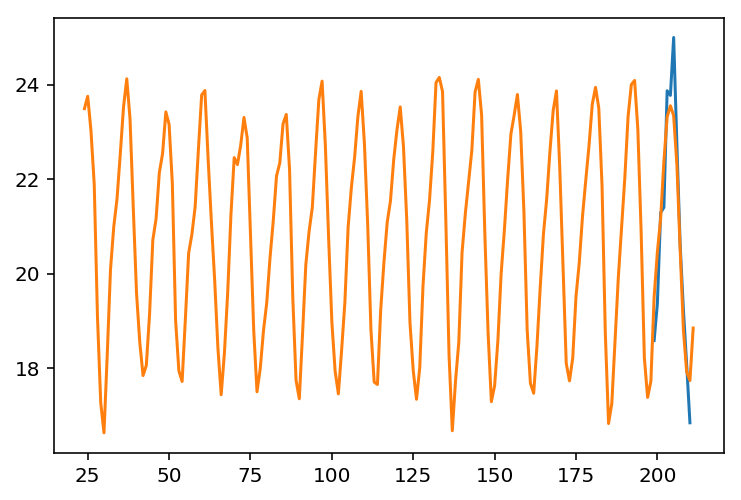

In [73]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1]))
#plt.plot(trainPlot)
plt.plot(testPlot)
plt.plot(Predict)
plt.show()

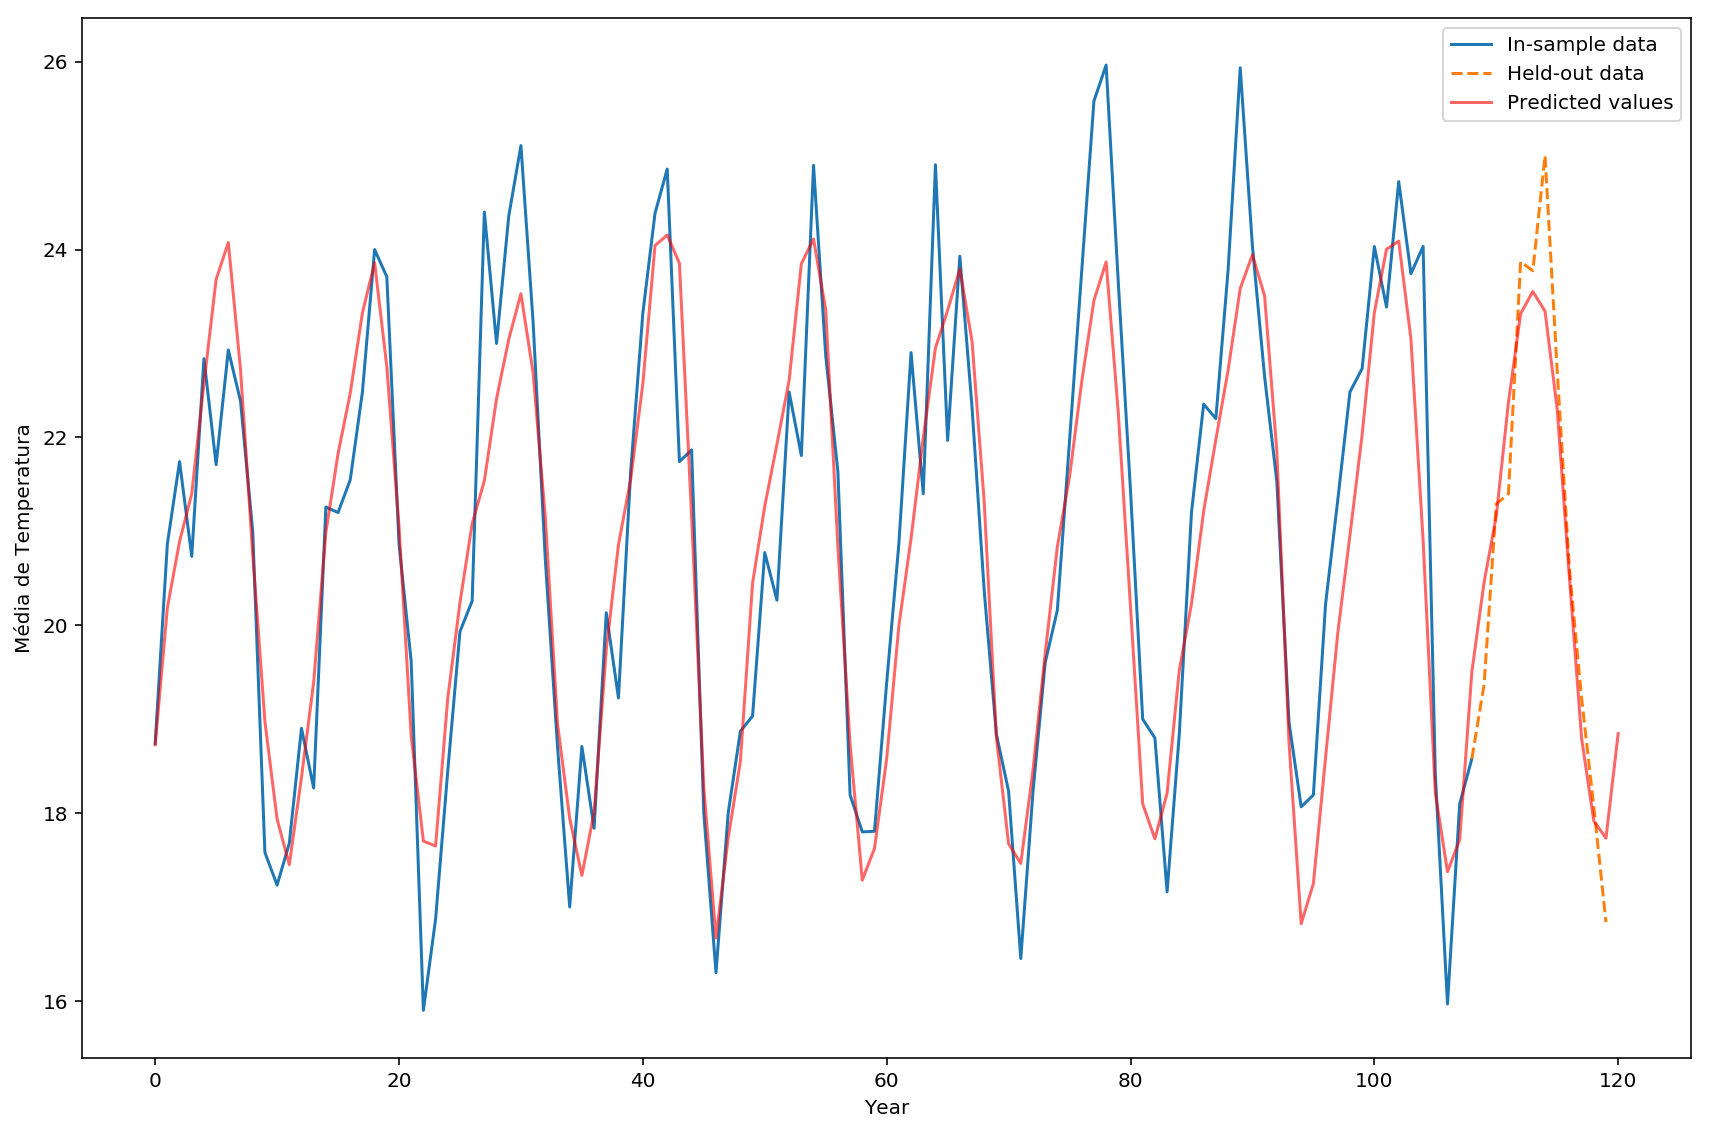

In [74]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(trainPlot[len(dataset)-121:], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(testPlot[len(dataset)-121:], label='Held-out data', linestyle='--')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(Predict[len(dataset)-121:], 'r', alpha=.6, label='Predicted values')

ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

In [75]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

In [76]:
# Training Set

rmse = get_rmse(trainY[0], trainPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(trainY[0], trainPredict[:,0])
print("MAPE: ", mape)

RMSE:  1.08582794204
MAPE:  4.23423011968


In [77]:
# Test Set

rmse = get_rmse(testY[0], testPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(testY[0], testPredict[:,0])
print("MAPE: ", mape)

RMSE:  0.811621385019
MAPE:  3.18081158301
